In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
%matplotlib inline
%reload_kedro
%load_ext nb_black

2022-04-01 15:01:20,224 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.


/opt/anaconda3/envs/transmilenio/lib/python3.8/site-packages/kedro/framework/context/context.py:32: DeprecationWarning: Accessing package_name via the context will be deprecated in Kedro 0.18.0.
  warn(


2022-04-01 15:01:20,307 - kedro.config.config - INFO - Config from path `/Users/juanazuero/Documents/Transporte/Transmilenio/transmi/conf/local` will override the following existing top-level config keys: dic_estacion_linea_int, dic_estacion_linea_raw, validaciones_troncal, validaciones_troncal_log_int, validaciones_troncal_log_raw, validaciones_troncal_summary@pandas, validaciones_troncal_zip_log_int, validaciones_troncal_zip_log_raw
2022-04-01 15:01:20,312 - root - INFO - ** Kedro project transmi
2022-04-01 15:01:20,312 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-04-01 15:01:20,403 - blib2to3.pgen2.driver - INFO - Generating grammar tables from /opt/anaconda3/envs/transmilenio/lib/python3.8/site-packages/blib2to3/Grammar.txt
2022-04-01 15:01:20,415 - blib2to3.pgen2.driver - INFO - Writing grammar tables to /Users/juanazuero/Library/Caches/black/22.1.0/Grammar3.8.0.final.0.pickle
2022-04-01 15:01:20,416 - blib2to3.pgen2.driver - INFO - 

<IPython.core.display.Javascript object>

In [3]:
BASE_VALIDACIONES_REQUEST = "https://storage.googleapis.com/validaciones_tmsa/"

<IPython.core.display.Javascript object>

In [4]:
links_data_transmi = catalog.load("links_data_transmi")

2022-04-01 15:01:20,491 - kedro.io.data_catalog - INFO - Loading data from `links_data_transmi` (CSVDataSet)...


<IPython.core.display.Javascript object>

In [6]:
result = None
for row in links_data_transmi.iterrows():
    link = row[1]["Link"]
    link_type = row[1]["Type"]
    link = link.replace(" ", "%20")
    if link_type == 1:
        print(link)
        excel = pd.read_excel(BASE_VALIDACIONES_REQUEST + "ValidacionTroncal/" + link)
        for i in range(8):
            for j in range(5):
                if excel.iloc[i, j] == "Fase":
                    start_coord = i, j
                    break
        cols = excel.iloc[start_coord[0], start_coord[1] :].values
        cols = [c.date() if type(c) == datetime.datetime else c.strip() for c in cols]
        excel = excel.iloc[start_coord[0] + 1 :, start_coord[1] :].copy()
        excel.columns = cols
        excel = excel[excel["Fase"] != "Total general"].copy()
        excel.drop(["Total general", "Fase"], axis=1, inplace=True)
        excel.dropna(how="all", inplace=True)
        excel.dropna(how="all", axis=1, inplace=True)
        excel_summary = (
            excel.drop(["Línea", "Acceso de Estación"], axis=1)
            .groupby(["Estación", "Intervalo"])
            .sum()
        )
        excel_summary = excel_summary.reset_index().melt(
            id_vars=["Estación", "Intervalo"], var_name="date", value_name="demand"
        )
        print(excel_summary.columns)
        result = pd.concat([result, excel_summary], ignore_index=True)

2022/02%20TM%20Resumen%20de%20Validaciones%20Troncales%20al%2028%20Feb%202022%20Intervalo%2015%20Mint.xlsx
Index(['Estación', 'Intervalo', 'date', 'demand'], dtype='object')
2022/01%20TM%20Resumen%20de%20Validaciones%20Troncales%20al%2031%20de%20Ene%202022%20Intervalo%2015%20Mint.xlsx
Index(['Estación', 'Intervalo', 'date', 'demand'], dtype='object')
2021/12%20TM%20Resumen%20de%20Validaciones%20Troncales%20al%2031%20Dic%202021%20Intervalo%2015%20Mint.xlsx
Index(['Estación', 'Intervalo', 'date', 'demand'], dtype='object')
2021/11%20TM%20Resumen%20de%20Validaciones%20Troncales%20al%2030%20Nov%202021%20Intervalo%2015%20Mint.xlsx
Index(['Estación', 'Intervalo', 'date', 'demand'], dtype='object')
2021/10%20TM%20Resumen%20de%20Validaciones%20Troncales%20al%2031%20Oct%202021%20Intervalo%2015%20Mint.xlsx
Index(['Estación', 'Intervalo', 'date', 'demand'], dtype='object')
2021/09%20TM%20Resumen%20de%20Validaciones%20Troncales%20al%2030%20Sep%202021%20Intervalo%2015%20Mint.xlsx
Index(['Estación',

2018/03%20TM%20Resumen%20de%20Validaciones%20Troncales%20al%2031%20Marzo%202018%20Intervalo%2015%20Mint.xlsx
Index(['Estación', 'Intervalo', 'date', 'demand'], dtype='object')
2018/02%20TM%20Resumen%20de%20Validaciones%20Troncales%20al%2028%20Febrero%202018%20Intervalo%2015%20Mint.xlsx
Index(['Estación', 'Intervalo', 'date', 'demand'], dtype='object')
2018/01%20TM%20Resumen%20de%20Validaciones%20Troncales%20al%2031%20Enero%202018%20Intervalo%2015%20Mint.xlsx
Index(['Estación', 'Intervalo', 'date', 'demand'], dtype='object')


<IPython.core.display.Javascript object>

In [12]:
type("asdf") == str

True

<IPython.core.display.Javascript object>

In [15]:
result["Intervalo"] = result["Intervalo"].apply(
    lambda x: datetime.time(int(x.split(":")[0]), int(x.split(":")[1]))
    if type(x) == str
    else x
)

<IPython.core.display.Javascript object>

In [19]:
result.to_parquet("prueba.parquet")

<IPython.core.display.Javascript object>

In [18]:
result["Estación"].unique()

array(['(02000) Cabecera Autopista Norte',
       '(02001) Centro Comercial Santa Fe', '(02101) Toberín',
       '(02102) Calle 161', '(02103) Mazurén', '(02104) Calle 146',
       '(02105) Calle 142', '(02200) Alcalá', '(02201) Prado',
       '(02202) Calle 127', '(02205) Calle 106', '(02300) Calle 100',
       '(02302) Virrey', '(02303) Calle 85', '(02304) Heroes',
       '(02502) Terminal', '(03000) Portal Suba', '(03001) LA CAMPIÑA',
       '(03002) SUBA - TV- 91', '(03003) 21 ANGELES', '(03004) GRATAMIRA',
       '(03005) SUBA - AV. BOYACA', '(03006) NIZA - CALLE 127',
       '(03007) HUMEDAL CORDOBA', '(03009) Av. Suba- Calle 116',
       '(03010) PUENTE LARGO', '(03011) SUBA - CALLE 100',
       '(03012) SUBA - CALLE 95', '(03013) RIO NEGRO',
       '(03014) SAN MARTIN', '(04000) Cabecera Calle 80',
       '(04001) Quirigua', '(04002) Carrera 90',
       '(04003) Avenida Ciudad de Cali', '(04004) La Granja',
       '(04100) Carrera 77', '(04101) Minuto de Dios',
       '(04102) 

<IPython.core.display.Javascript object>

In [17]:
result.dtypes

Estación     object
Intervalo    object
date         object
demand        int64
dtype: object

<IPython.core.display.Javascript object>

In [10]:
result["Intervalo"].unique()

array([datetime.time(0, 0), datetime.time(0, 15), datetime.time(4, 0),
       datetime.time(4, 15), datetime.time(4, 30), datetime.time(4, 45),
       datetime.time(5, 0), datetime.time(5, 15), datetime.time(5, 30),
       datetime.time(5, 45), datetime.time(6, 0), datetime.time(6, 15),
       datetime.time(6, 30), datetime.time(6, 45), datetime.time(7, 0),
       datetime.time(7, 15), datetime.time(7, 30), datetime.time(7, 45),
       datetime.time(8, 0), datetime.time(8, 15), datetime.time(8, 30),
       datetime.time(8, 45), datetime.time(9, 0), datetime.time(9, 15),
       datetime.time(9, 30), datetime.time(9, 45), datetime.time(10, 0),
       datetime.time(10, 15), datetime.time(10, 30),
       datetime.time(10, 45), datetime.time(11, 0), datetime.time(11, 15),
       datetime.time(11, 30), datetime.time(11, 45), datetime.time(12, 0),
       datetime.time(12, 15), datetime.time(12, 30),
       datetime.time(12, 45), datetime.time(13, 0), datetime.time(13, 15),
       datetime.tim

<IPython.core.display.Javascript object>

In [26]:
excel

,Etiquetas de fila,01/05/2017,02/05/2017,03/05/2017,04/05/2017,05/05/2017,06/05/2017,07/05/2017,08/05/2017,09/05/2017,...,23/05/2017,24/05/2017,25/05/2017,26/05/2017,27/05/2017,28/05/2017,29/05/2017,30/05/2017,31/05/2017,Total general
6,(11) Zona K Calle 26,37714,140871,141670,144464,146227,90701,42044,138663,137253,...,132526,131429,119882,130711,67940,30260,27604,129395,126019,3355528
7,(06000) Portal Eldorado,14770,49937,49684,49786,50044,32973,15660,48089,49041,...,49131,48883,47479,48289,30776,14669,14089,48058,47178,1245920
8,(01) Acceso Alimentación Sur,4067,15317,15255,15236,15357,10460,4580,14319,13241,...,14352,15217,14527,14687,10058,4354,4055,14707,14233,380119
9,04:00,NaN,NaN,1,2,3,NaN,NaN,NaN,1,...,NaN,1,1,1,NaN,NaN,NaN,2,NaN,19
10,04:15,NaN,5,4,5,5,NaN,NaN,5,4,...,15,11,10,7,NaN,NaN,NaN,15,4,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54070,20:30,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
54071,(1986) L061|San Diego B - 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77
54072,07:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54
54073,08:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23


<IPython.core.display.Javascript object>

22/03/31 17:04:12 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 937897 ms exceeds timeout 120000 ms
22/03/31 17:04:12 WARN SparkContext: Killing executors is not supported by current scheduler.


In [15]:
excel["Fase "]

6               Fase 3
7               Fase 3
8               Fase 3
9               Fase 3
10              Fase 3
             ...      
64956              NaN
64957              NaN
64958              NaN
64959              NaN
64960    Total general
Name: Fase , Length: 64955, dtype: object

<IPython.core.display.Javascript object>

In [73]:
link

'2012/08%20AGO%2012_VALIDACIONES%20TRONCALES.xlsx'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
for i in range(8):
    for j in range(5):
        if excel_type_1.iloc[i, j] == "Fase":
            start_coord = i, j
            break

<IPython.core.display.Javascript object>

In [25]:
cols = excel_type_1.iloc[start_coord[0], start_coord[1] :].values

<IPython.core.display.Javascript object>

In [34]:
cols = [c.date() if type(c) == datetime.datetime else c for c in cols]

<IPython.core.display.Javascript object>

In [28]:
excel_type_1 = excel_type_1.iloc[start_coord[0] + 1 :, start_coord[1] :].copy()

<IPython.core.display.Javascript object>

In [35]:
excel_type_1.columns = cols

<IPython.core.display.Javascript object>

In [42]:
excel_type_1.drop("Total general",'Fase', axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [44]:
excel_type_1 = excel_type_1[excel_type_1["Fase"] != "Total general"].copy()

<IPython.core.display.Javascript object>

In [46]:
excel_type_1.dropna(how="all", inplace=True)
excel_type_1.dropna(how="all", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [54]:
excel_type_1_summary = (
    excel_type_1.drop(["Fase", "Línea", "Acceso de Estación"], axis=1)
    .groupby(["Estación", "Intervalo"])
    .sum()
)

<IPython.core.display.Javascript object>

In [57]:
excel_type_1_summary = excel_type_1_summary.reset_index().melt(
    id_vars=["Estación", "Intervalo"], var_name="date", value_name="demand"
)

<IPython.core.display.Javascript object>

In [58]:
excel_type_1_summary

,Estación,Intervalo,date,demand
0,(02000) Cabecera Autopista Norte,00:00:00,2022-02-01,0
1,(02000) Cabecera Autopista Norte,00:15:00,2022-02-01,0
2,(02000) Cabecera Autopista Norte,04:00:00,2022-02-01,1
3,(02000) Cabecera Autopista Norte,04:15:00,2022-02-01,45
4,(02000) Cabecera Autopista Norte,04:30:00,2022-02-01,120
...,...,...,...,...
373879,(57503) Ampliacion San Mateo,22:15:00,2022-02-28,3
373880,(57503) Ampliacion San Mateo,22:30:00,2022-02-28,0
373881,(57503) Ampliacion San Mateo,22:45:00,2022-02-28,1
373882,(57503) Ampliacion San Mateo,23:00:00,2022-02-28,0


<IPython.core.display.Javascript object>

In [51]:
excel_type_1.pivot(index)

,Fase,Línea,Estación,Acceso de Estación,Intervalo,2022-02-01,2022-02-02,2022-02-03,2022-02-04,2022-02-05,...,2022-02-19,2022-02-20,2022-02-21,2022-02-22,2022-02-23,2022-02-24,2022-02-25,2022-02-26,2022-02-27,2022-02-28
6,Fase 3,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,00:00:00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Fase 3,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,03:45:00,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8,Fase 3,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,04:00:00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Fase 3,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,04:15:00,27,35,27,17,17,...,15,4,20,29,39,17,21,13,2,21
10,Fase 3,(11) Zona K Calle 26,(06000) Portal Eldorado,(01) PLAT2 ALIM-DESAL FONTIBÓN/FONTIBÓN CENTRO...,04:30:00,49,40,63,45,43,...,44,9,44,57,39,67,48,24,12,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43136,Fase 3,(40) Zona T Ciudad Bolívar,(40003) Mirador del Paraiso,(01) Acceso Peatonal,21:00:00,4,10,9,7,17,...,15,4,10,11,10,10,9,31,12,9
43137,Fase 3,(40) Zona T Ciudad Bolívar,(40003) Mirador del Paraiso,(01) Acceso Peatonal,21:15:00,5,7,5,11,24,...,17,0,6,7,12,22,6,17,0,3
43138,Fase 3,(40) Zona T Ciudad Bolívar,(40003) Mirador del Paraiso,(01) Acceso Peatonal,21:30:00,3,2,1,5,20,...,11,0,1,9,3,1,6,14,0,10
43139,Fase 3,(40) Zona T Ciudad Bolívar,(40003) Mirador del Paraiso,(01) Acceso Peatonal,21:45:00,2,3,1,2,20,...,18,0,3,0,7,1,7,3,0,1


<IPython.core.display.Javascript object>

In [50]:
excel_type_1["Intervalo"].iloc[0]

datetime.time(0, 0)

<IPython.core.display.Javascript object>

<AxesSubplot:>

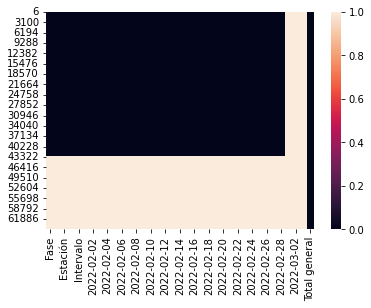

<IPython.core.display.Javascript object>

In [38]:
sns.heatmap(excel_type_1.isna())

In [8]:
pd.read_excel(
    BASE_VALIDACIONES_REQUEST
    + "2022/02 TM Resumen de Validaciones Troncales al 28 Feb 2022 Intervalo 15 Mint.xlsx"
)

InvalidURL: URL can't contain control characters. '/validaciones_tmsa/2022/02 TM Resumen de Validaciones Troncales al 28 Feb 2022 Intervalo 15 Mint.xlsx' (found at least ' ')

<IPython.core.display.Javascript object>

In [ ]:

http_response = urlopen(url)
zipfile = ZipFile(BytesIO(http_response.read()))
zipfile.extractall(path=extract_to)

In [ ]:

def download_and_unzip(url, extract_to='.'):